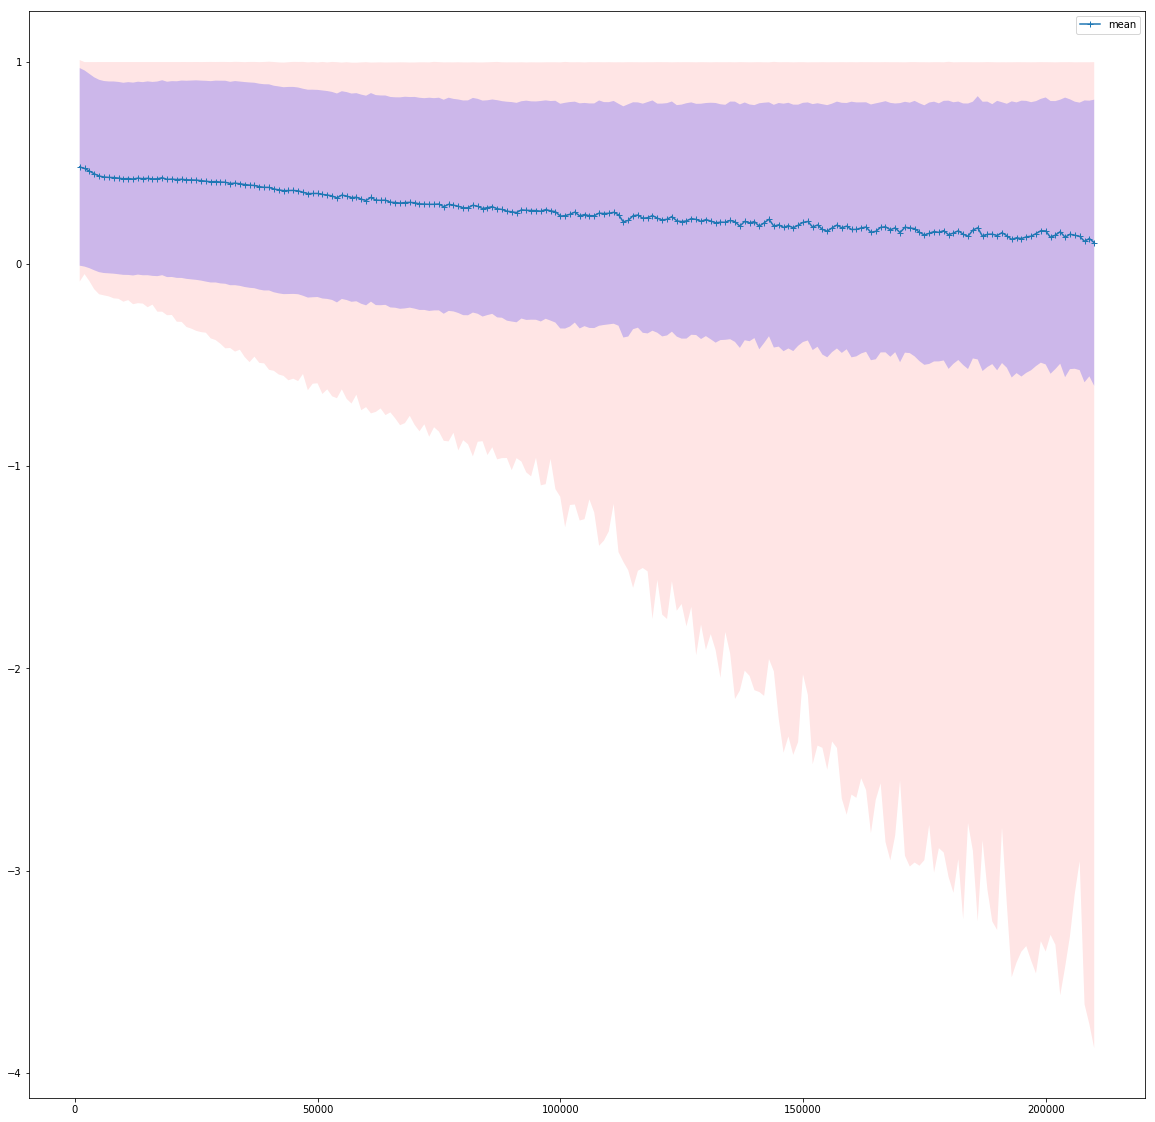

mean:0.10606694103972265, std:0.707983648430683, max:0.9995029171599276, min:-3.8798162363125206
i:210000	src:Var([0.61 0.96])	true:Var([6.68081624])	pred:Var([6.67521243]), max_err:[0.00047383], mean_err:[5.30232654e-05]


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
"""
p.17-18
"""
import itertools
import random

import numpy
import numpy.random

import nn_functor.functions
import nn_functor.functions.error
from nn_functor.functions.sigmoid import sigmoid_derivative, sigmoid, sigmoid_derivative_n
from nn_functor.report_simple import AggregateStore,PylabReporter
import nn_functor.var

agg = AggregateStore()

class L1Para(nn_functor.functions.Learn):
    def implement(self, a, p):
        """(p, a) -> b

        Parameters
        ----------
        a : tuple[numpy.array]
        p : tuple[numpy.array]

        Returns
        -------
        numpy.array
        """
        a = a[0]
        p00, p01, p10, b00, b01, q0, q1, b1 = p

        return numpy.array([
                q0 * sigmoid(p00 * a[0] + p10 * a[1] + b00)
                + q1 * sigmoid(p01 * a[0] + b01)
                + b1
        ]).reshape(1)

    def update(self, a, b, p):
        """(p, a, b) -> p

        Parameters
        ----------
        a : tuple[numpy.array]
        b : numpy.array
        p : tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        a = a[0]
        p00, p01, p10, b00, b01, q0, q1, b1 = p

        beta = [
            p00 * a[0] + p10 * a[1] + b00,
            p01 * a[0] + b01
        ]

        beta_sigma_derivative = [
            sigmoid_derivative(beta[0]),
            sigmoid_derivative(beta[1])
        ]
        beta_sigma = [
            sigmoid(beta[0]),
            sigmoid_derivative(beta[1])
        ]

        gamma = 1

        return (
            p00 - self.eps * (i - b) * gamma * q0 * beta_sigma_derivative[0] * a[0],
            p01 - self.eps * (i - b) * gamma * q0 * beta_sigma_derivative[0] * a[1],
            p10 - self.eps * (i - b) * gamma * q1 * beta_sigma_derivative[1] * a[0],
            b00 - self.eps * (i - b) * gamma * q0 * beta_sigma_derivative[0],
            b01 - self.eps * (i - b) * gamma * q1 * beta_sigma_derivative[1],
            q0 - self.eps * (i - b) * gamma * beta_sigma[0],
            q1 - self.eps * (i - b) * gamma * beta_sigma[1],
            b1 - self.eps * (i - b) * gamma
        )

    def request(self, a, b, p):
        """(p, a, b) -> a

        Parameters
        ----------
        a: tuple[numpy.array]
        b: numpy.array
        p: tuple[numpy.array]

        Returns
        -------
        tuple[numpy.array]
        """
        i = self.implement(a, p)

        agg.add_data(self.test_request_differential(a, b, p))

        a = a[0]
        p00, p01, p10, b00, b01, q0, q1, b1 = p

        beta = [
            sigmoid_derivative(p00 * a[0] + p10 * a[1] + b00),
            sigmoid_derivative(p01 * a[0] + b01)
        ]

        gamma = 1

        return numpy.array([
            a[0] - (i - b) * gamma * (q0 * beta[0] * p00 + q1 * beta[1] * p10),
            a[1] - (i - b) * gamma * (q0 * beta[0] * p01)
        ]).reshape(2),

    def test_request_differential(self, a, b, p):
        i = self.implement(a, p)

        a = a[0]
        p00, p01, p10, b00, b01, q0, q1, b1 = p

        beta = [
            sigmoid_derivative(p00 * a[0] + p10 * a[1] + b00),
            sigmoid_derivative(p01 * a[0] + b01)
        ]

        beta2 = [
            sigmoid_derivative_n(p00 * a[0] + p10 * a[1] + b00, 2),
            sigmoid_derivative_n(p01 * a[0] + b01, 2)
        ]

        h = q0 * beta[0] * p00 + q1 * beta[1] * p10
        k = q0 * beta[0] * p01

        return numpy.array([
            1 - (h * h + (i - b) * (q0 * beta2[0] * p00 * p00 + q1 * beta2[1] * p10 * p10)),
            - (h * k + (i - b) * (q0 * beta2[0] * p00 * p01)),
            - (h * k + (i - b) * (q0 * beta2[0] * p00 * p01)),
            1 - (k * k + (i - b) * (q0 * beta2[0] * p01 * p01)),
        ]).reshape(2, 2),


class L1Node(nn_functor.functions.Node):
    def __init__(self, eps):
        super().__init__(L1Para(eps))

        self.param_name = [
            "p00", "p01", "p10", "b00", "b01", "q0", "q1", "b1"
        ]

        self.p00 = numpy.random.randn(1)
        self.p01 = numpy.random.randn(1)
        self.p10 = numpy.random.randn(1)
        self.b00 = numpy.random.randn(1)
        self.b01 = numpy.random.randn(1)

        self.q0 = numpy.random.randn(1)
        self.q1 = numpy.random.randn(1)
        self.b1 = numpy.random.randn(1)


if __name__ == '__main__':
    random.seed(0)
    numpy.random.seed(0)


    def f(src):
        return sigmoid(src[0] * 2 + src[1] + 1) * 3 + sigmoid(src[0] * -1 + 2) + 3


    xy = [numpy.array(i) for i in
          itertools.product(numpy.arange(0, 1, 0.01), numpy.arange(0, 1, 0.01))]

    l1 = L1Node(0.1)
    err_f = nn_functor.functions.error.MeanSquaredErrorNode()

    reporter = PylabReporter(agg, 1000)

    err_hist = []
    count = 0
    report = 1000

    for i in range(1000):
        random.shuffle(xy)

        for src in xy:
            var_src = nn_functor.var.Var(src, has_link_info=False)
            var_dst = nn_functor.var.Var(f(src), has_link_info=False)
            v = l1(var_src)
            err = err_f(v, var_dst)
            err_f.backward_chain()

            l1.request(var_src)
            reporter.run()

            err_f.update_chain()

            err_hist.append(err.data)
            if count % report == 0:
                print(
                    f"i:{count}\tsrc:{var_src}\ttrue:{var_dst}\tpred:{v}, "
                    f"max_err:{max(err_hist)}, mean_err:{sum(err_hist) / report}")
                err_hist = []
            count += 1
        #     break
        # break

    print("result")
    for src in xy[:5]:
        var_src = nn_functor.var.Var(src, has_link_info=False)
        v = l1(var_src)
        print(f"{src} -> {f(src)}, predict:{v.data}")
